In [ ]:
!mkdir kitti_stereo_2015
!wget -O kitti_stereo_2015/part_1.zip \
    https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0032/2011_09_26_drive_0032_sync.zip

In [ ]:
!unzip kitti_stereo_2015/part_1.zip -d kitti_stereo_2015

In [ ]:
!mkdir kitti_stereo_2012_training_data

In [ ]:
import requests
from urllib.parse import urlencode
import os


# based on https://ru.stackoverflow.com/a/1088518
def download_from_yadisk(short_url: str, filename: str, target_dir: str):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    final_url = base_url + urlencode(dict(public_key=short_url))
    response = requests.get(final_url)
    download_url = response.json()['href']

    download_response = requests.get(download_url)
    target_file = os.path.join(target_dir, filename)
    with open(target_file, 'wb') as f:
        f.write(download_response.content)

In [ ]:
if not os.path.exists('./kitti_stereo_2012_training_data.zip'):
    download_from_yadisk("https://disk.yandex.ru/d/WrA28IyHHYENOw",
                               "kitti_stereo_2012_training_data.zip",
                               target_dir='.')

In [ ]:
!unzip -q ./kitti_stereo_2012_training_data.zip

In [ ]:
!cp kitti_stereo_2015/2011_09_26/2011_09_26_drive_0032_sync/image_02/data/*.png \
    kitti_stereo_2012_training_data/train/colored_0/

!cp kitti_stereo_2015/2011_09_26/2011_09_26_drive_0032_sync/image_03/data/*.png \
    kitti_stereo_2012_training_data/train/colored_1/

In [ ]:
from typing import Optional, Union, Tuple, List

import time
import random
from pathlib import Path
from tqdm import tqdm
from IPython import display
from functools import partial
from dataclasses import dataclass, asdict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
import torchvision
from torchvision.io import read_image

from PIL import Image
import skimage
import skimage.io

import numpy as np
from matplotlib import pyplot as plt

In [ ]:
class KITTIStereoRAM(Dataset):
    def __init__(self, root, train=True, transforms=None):
        super(KITTIStereoRAM, self).__init__()

        self.root = Path(root)
        if train:
            self.path_to_dataset = self.root / 'train'
        else:
            self.path_to_dataset = self.root / 'val'

        self.transforms = transforms
        self.left_images = []
        self.right_images = []
        for left_image_path in tqdm((self.path_to_dataset / 'colored_0').rglob('*.png')):
            right_image_path = left_image_path.as_posix().replace('colored_0', 'colored_1')
            left_image_path = left_image_path.as_posix()

            left_image = read_image(left_image_path)
            right_image = read_image(right_image_path)

            self.left_images.append(left_image)
            self.right_images.append(right_image)

    def __len__(self):
        return len(self.left_images)

    def __getitem__(self, index):
        left_img = self.left_images[index]
        right_img = self.right_images[index]

        if self.transforms is not None:
            left_img, right_img = self.transforms(left_img, right_img)
        return left_img, right_img

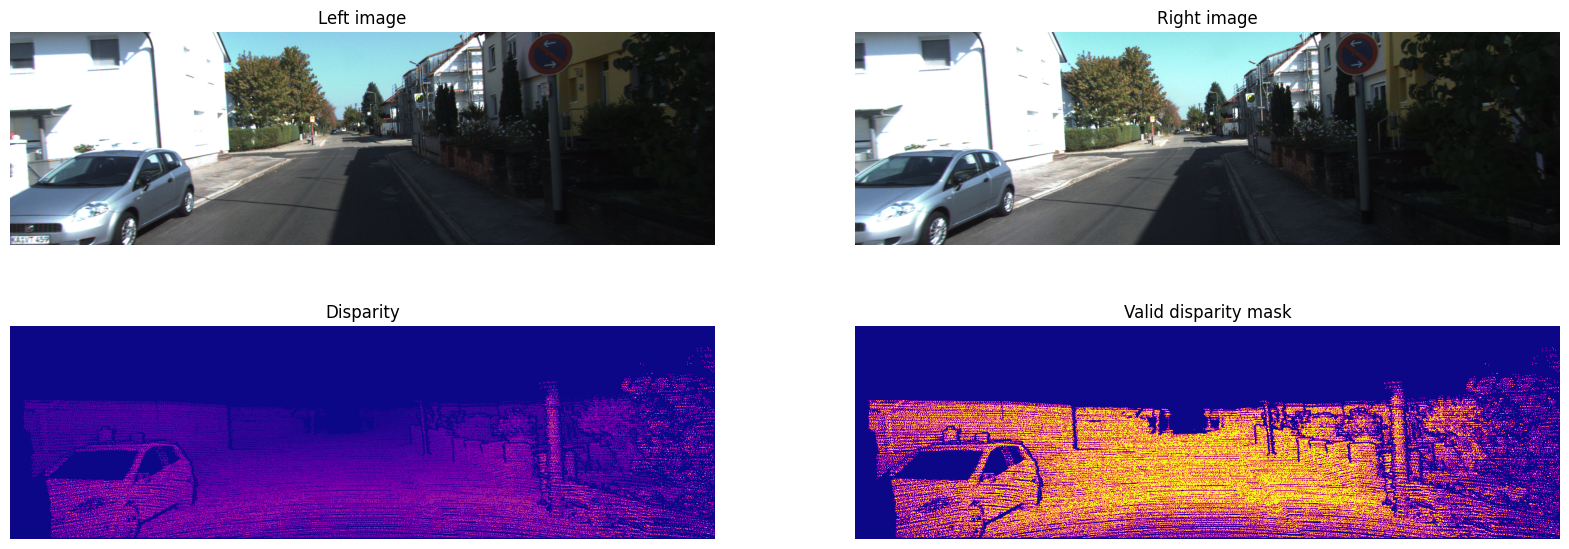

In [ ]:
img_name = "000002_10.png"

plt.figure(figsize=(20, 7), dpi=100)

plt.subplot(2, 2, 1)
plt.title('Left image')
plt.imshow(Image.open(
    f'./kitti_stereo_2012_training_data/train/colored_0/{img_name}'))
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Right image')
plt.imshow(Image.open(
    f'./kitti_stereo_2012_training_data/train/colored_1/{img_name}'))
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Disparity')
disp = np.array(Image.open(
    f'./kitti_stereo_2012_training_data/train/disp_noc/{img_name}'))
plt.imshow(disp / 255, "plasma")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Valid disparity mask')
plt.imshow(disp > 0, "plasma")
plt.axis('off')
plt.show()

In [ ]:
def pad_to_size(images, min_height, min_width):
    if images.shape[1] < min_height:
        images = torchvision.transforms.functional.pad(
            images, (0, 0, 0, min_height-images.shape[1]),
        )
    if images.shape[2] < min_width:
        images = torchvision.transforms.functional.pad(
            images, (0, 0, min_width - images.shape[2], 0),
        )
    return images


def normalize(image):
    # torch.uint8 -> torch.float32, [0; 1]
    return image / 255.


color_jitter = torchvision.transforms.ColorJitter(0.2, 0.2, 0.2, 0.2)

# min kitti shape is [370, 1226], max shape is [376, 1242]
PAD_HEIGHT = 128 * 3
PAD_WIDTH = 1280

RESIZES_HEIGHT = PAD_HEIGHT
RESIZES_WIDTH = PAD_WIDTH


def transforms_train(left_image, right_image):
    left_image = color_jitter(left_image)
    right_image = color_jitter(right_image)
    if random.random() < 0.5:
        left_image = torchvision.transforms.functional.hflip(left_image)
        right_image = torchvision.transforms.functional.hflip(right_image)

    left_image = pad_to_size(left_image, PAD_HEIGHT, PAD_WIDTH)
    right_image = pad_to_size(right_image, PAD_HEIGHT, PAD_WIDTH)

    left_image = torchvision.transforms.functional.resize(
        left_image, (RESIZES_HEIGHT, RESIZES_WIDTH)
    )
    right_image = torchvision.transforms.functional.resize(
        right_image, (RESIZES_HEIGHT, RESIZES_WIDTH)
    )
    return normalize(left_image), normalize(right_image)


def transforms_test(left_image, right_image):
    left_image = pad_to_size(left_image, PAD_HEIGHT, PAD_WIDTH)
    right_image = pad_to_size(right_image, PAD_HEIGHT, PAD_WIDTH)

    left_image = torchvision.transforms.functional.resize(
        left_image, (RESIZES_HEIGHT, RESIZES_WIDTH)
    )
    right_image = torchvision.transforms.functional.resize(
        right_image, (RESIZES_HEIGHT, RESIZES_WIDTH)
    )
    return normalize(left_image), normalize(right_image)

In [ ]:
train_dataset = KITTIStereoRAM(
    root="./kitti_stereo_2012_training_data/",
    train=True, transforms=transforms_train
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=12
)

validation_dataset = KITTIStereoRAM(
    root="./kitti_stereo_2012_training_data/",
    train=False, transforms=transforms_test
)
validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=1, shuffle=False, num_workers=4
)

In [ ]:
class ConvBlock(nn.Sequential):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        activation: nn.Module = nn.ReLU,
        normalization: bool = True,
        padding: Optional[int] = None,
    ):
        if padding is None:
            padding = (kernel_size - 1) // 2

        layers = [
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding,
                bias=not normalization
            ),
        ]
        if normalization:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(activation())
        super().__init__(*layers)


class EncoderBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self._in_channels = in_channels
        self._out_channels = out_channels
        self._kernel_size = kernel_size

        self.convs = nn.Sequential(
            ConvBlock(
                self._in_channels, self._out_channels, self._kernel_size,
                stride=2, activation=partial(nn.ELU, inplace=True)
            ),
            ConvBlock(
                self._out_channels, self._out_channels, self._kernel_size,
                stride=1, activation=partial(nn.ELU, inplace=True)
            )
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.convs(input)

In [ ]:
class DisparityHead(nn.Module):

    def __init__(self, in_channels: int, disparity_max: float):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels=2,
                              kernel_size=3, padding=1)
        self._disparity_max = disparity_max

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.conv(input)
        return torch.sigmoid(x)*self._disparity_max


class DecoderBlock(nn.Module):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        scale: float = 2.0,
        with_skip: bool = False,
        use_previous_disparity: bool = False,
        with_disparity_head: bool = False,
        disparity_max: Optional[float] = None,
    ):
        super().__init__()
        self._in_channels = in_channels
        self._out_channels = out_channels
        self._kernel_size = kernel_size
        self._scale = scale

        self.with_skip = with_skip
        self.use_previous_disparity = use_previous_disparity
        self.with_disparity_head = with_disparity_head

        self.up_conv = nn.Sequential(
            nn.Upsample(scale_factor=self._scale, mode='nearest'),
            ConvBlock(
                self._in_channels, self._out_channels, self._kernel_size,
                activation=partial(nn.ELU, inplace=True), normalization=False
            )
        )

        in_channels = self._out_channels
        if self.with_skip:
            in_channels *= 2
        if self.use_previous_disparity:
            in_channels += 2
        self.conv = ConvBlock(
            in_channels, self._out_channels,
            self._kernel_size, activation=partial(nn.ELU, inplace=True)
        )

        if self.with_disparity_head:
            assert disparity_max is not None
            self.disparity_head = DisparityHead(
                self._out_channels, disparity_max
            )

    def forward(
        self,
        input: torch.Tensor,
        skip_input: Optional[torch.Tensor] = None,
        previous_disparity_map: Optional[torch.Tensor] = None
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        x = self.up_conv(input)
        if self.with_skip:
          x = torch.cat((x,skip_input), dim=1)
        if self.use_previous_disparity:
          x = torch.cat((x,previous_disparity_map), dim=1)
        x = self.conv(x)
        if self.with_disparity_head:
          return x, self.disparity_head(x)
        return x

In [ ]:
@dataclass
class EncoderBlockConfig:
    in_channels: int
    out_channels: int
    kernel_size: int


@dataclass
class DecoderBlockConfig:
    in_channels: int
    out_channels: int
    kernel_size: int = 3
    scale: float = 2.0
    with_skip: bool = False
    use_previous_disparity: bool = False
    with_disparity_head: bool = False
    disparity_max: Optional[float] = None


@dataclass
class DisparityNetConfig:
    encoder: Tuple[EncoderBlockConfig, ...] = (
        EncoderBlockConfig(3, 32, 7),
        EncoderBlockConfig(32, 64, 5),
        EncoderBlockConfig(64, 128, 3),
        EncoderBlockConfig(128, 256, 3),
        EncoderBlockConfig(256, 512, 3),
        EncoderBlockConfig(512, 512, 3),
        EncoderBlockConfig(512, 512, 3)
    )

    disparity_maxes: Tuple[float, ...] = (
        0.3, 0.3, 0.3, 0.3
    )
    image_scale = 1
    decoder: Tuple[DecoderBlock, ...] = (
        DecoderBlockConfig(512, 512, with_skip=True),
        DecoderBlockConfig(512, 512, with_skip=True),
        DecoderBlockConfig(512, 256, with_skip=True),
        DecoderBlockConfig(
            256, int(128 * image_scale), with_skip=True,
            with_disparity_head=True,
            disparity_max=disparity_maxes[0]
        ),
        DecoderBlockConfig(
            128, int(64 * image_scale), with_skip=True,
            with_disparity_head=True,
            use_previous_disparity=True,
            disparity_max=disparity_maxes[1]
        ),
        DecoderBlockConfig(
            64, int(32 * image_scale), with_skip=True,
            with_disparity_head=True,
            use_previous_disparity=True,
            disparity_max=disparity_maxes[2]
        ),
        DecoderBlockConfig(
            32, int(16 * image_scale),
            with_disparity_head=True,
            use_previous_disparity=True,
            disparity_max=disparity_maxes[3]
        ),
    )

In [ ]:
class DisparityNet(nn.Module):
    # we have strong assumption about network topology!

    def __init__(self, config: DisparityNetConfig):
        super().__init__()
        self._config = config

        self.encoder = nn.ModuleList([
            EncoderBlock(**asdict(encoder_config))
            for encoder_config in self._config.encoder
        ])

        self.decoder = nn.ModuleList([
            DecoderBlock(**asdict(decoder_config))
            for decoder_config in self._config.decoder
        ])

    def forward(self, input: torch.Tensor) -> Tuple[torch.Tensor, ...]:
          m = nn.Upsample(scale_factor=2, mode='nearest')
          out = input
          outs = []
          disp_maps = []
          n = len(DisparityNetConfig.encoder)
          for block in self.encoder:
              out = block(out)
              outs.append(out)
          for block in self.decoder:
            if block.with_skip==True and block.with_disparity_head==False and block.use_previous_disparity==False:
              out = block(out, outs[n-2])
              n-=1
            elif block.with_skip==True and block.with_disparity_head==True and block.use_previous_disparity==False:
              out, map = block(out, outs[n-2])
              disp_maps.append(map)
              n-=1
            elif block.with_skip==True and block.with_disparity_head==True and block.use_previous_disparity==True:
              out, map = block(out, outs[n-2], m(disp_maps[-1]))
              disp_maps.append(map)
              n-=1
            elif block.with_skip==False and block.with_disparity_head==True and block.use_previous_disparity==True:
              out, map = block(out, outs[n-2], m(disp_maps[-1]))
              disp_maps.append(map)
          return tuple(disp_maps)

In [ ]:
disparity_net_config = DisparityNetConfig()
model = DisparityNet(disparity_net_config)

print(model(torch.randn(1, 3, 384, 1280)))

In [ ]:
disparity_maps = model(torch.randn(1, 3, PAD_HEIGHT, PAD_WIDTH))
disparity_maps[0].shape

torch.Size([1, 2, 48, 160])

In [ ]:
for i, disparity_map in enumerate(disparity_maps):
    target_shape = (2, PAD_HEIGHT // (2 ** (3 - i)), PAD_WIDTH // (2 ** (3 - i)))
    assert disparity_map.shape[1:] == target_shape, f"get {disparity_map.shape[1:]} but expect {target_shape}"

In [ ]:
def apply_disparity(image, disparity_map):
    batch_size, _, height, width = image.size()

    x_base = torch.linspace(0, 1, width).repeat(
        batch_size, height, 1).type_as(image)
    y_base = torch.linspace(0, 1, height).repeat(
        batch_size, width, 1).transpose(1, 2).type_as(image)

    x_shifts = disparity_map[:, 0, :, :]
    flow_field = torch.stack((x_base + x_shifts, y_base), dim=3)
    output = F.grid_sample(image, flow_field * 2 - 1, mode='bilinear',
                  padding_mode='zeros', align_corners=False)

    return output


class DisparityConsistencyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_loss = nn.L1Loss()

    def forward(self, left_disparity_map, right_disparity_map):

        output1 = apply_disparity(right_disparity_map,-left_disparity_map)
        l1 = self.l1_loss(output1, left_disparity_map)
        output2 = apply_disparity(left_disparity_map,right_disparity_map)
        l2 = self.l1_loss(output2, right_disparity_map)

        return l1+l2

In [ ]:
class DisparitySmoothnessLoss(nn.Module):

    @staticmethod
    def x_grad(image):
        img = F.pad(image, (0, 1, 0, 0), mode='replicate')
        grad_x = img[:, :, :, :-1] - img[:, :, :, 1:]
        return grad_x

    @staticmethod
    def y_grad(image):
        img = F.pad(image, (0, 0, 0, 1), mode='replicate')
        grad_y = img[:, :, :-1, :] - img[:, :, 1:, :]
        return grad_y


    def forward(self, disparity_map, image):
        # TODO
        disp_gradients_x = self.x_grad(disparity_map)
        disp_gradients_y = self.y_grad(disparity_map)

        image_gradients_x = self.x_grad(image)
        image_gradients_y = self.y_grad(image)

        weights_x = torch.exp(-torch.mean(torch.abs(image_gradients_x), 1, keepdim=True))
        weights_y = torch.exp(-torch.mean(torch.abs(image_gradients_y), 1, keepdim=True))

        smoothness_x = disp_gradients_x * weights_x
        smoothness_y = disp_gradients_y * weights_y

        sum = torch.abs(smoothness_x) + torch.abs(smoothness_y)

        return sum

In [ ]:
def gaussian(window_size: int, sigma: float):
    def gauss_fcn(x):
        return -(x - window_size // 2) ** 2 / float(2 * sigma ** 2)
    gauss = torch.stack([
        torch.exp(torch.tensor(gauss_fcn(x))) for x in range(window_size)
    ])
    return gauss / gauss.sum()


def get_gaussian_kernel2d(
    ksize: Tuple[int, int],
    sigma: Tuple[float, float]
) -> torch.Tensor:
    ksize_x, ksize_y = ksize
    sigma_x, sigma_y = sigma
    kernel_x: torch.Tensor = gaussian(ksize_x, sigma_x)
    kernel_y: torch.Tensor = gaussian(ksize_y, sigma_y)
    kernel_2d: torch.Tensor = torch.matmul(
        kernel_x.unsqueeze(-1), kernel_y.unsqueeze(-1).t())
    return kernel_2d


class DSSIMLoss(nn.Module):

    def __init__(self, window_size: int, max_val: float = 1.0):
        super().__init__()
        self._window_size = window_size
        self._max_val = max_val

        self.window = get_gaussian_kernel2d(
            (window_size, window_size), (1.5, 1.5))
        self.padding = (window_size - 1) // 2

        self.C1: float = (0.01 * self._max_val) ** 2
        self.C2: float = (0.03 * self._max_val) ** 2

    def filter2D(
        self, input: torch.Tensor, kernel: torch.Tensor, channel: int
    ) -> torch.Tensor:
        return F.conv2d(input, kernel, padding=self.padding, groups=channel)

    def forward(self, image1, image2):
        b, c, h, w = image1.shape
        tmp_kernel = self.window.to(image1.device).to(image1.dtype)
        kernel = tmp_kernel.repeat(c, 1, 1, 1)

        # compute local mean per channel
        mu1 = self.filter2D(image1, kernel, c)
        mu2 = self.filter2D(image2, kernel, c)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        # compute local sigma per channel
        sigma1_sq = self.filter2D(image1 * image1, kernel, c) - mu1_sq
        sigma2_sq = self.filter2D(image2 * image2, kernel, c) - mu2_sq
        sigma12 = self.filter2D(image1 * image2, kernel, c) - mu1_mu2

        ssim_map = ((2 * mu1_mu2 + self.C1) * (2 * sigma12 + self.C2)) / \
            ((mu1_sq + mu2_sq + self.C1) * (sigma1_sq + sigma2_sq + self.C2))

        loss = torch.clamp(1. - ssim_map, min=0, max=1) / 2.
        return loss.mean()


class AppearanceMatchingLoss(nn.Module):

    def __init__(self, alpha: float):
        super().__init__()
        self._alpha = alpha

        self.l1_loss = nn.L1Loss()
        self.dssim_loss = DSSIMLoss(3)

    def forward(
        self,
        left_disparity_map,
        right_disparity_map,
        left_image,
        right_image
    ):

        left_image_rec = apply_disparity(right_image, -left_disparity_map)

        right_image_rec = apply_disparity(left_image, right_disparity_map)

        ssim_left = self.dssim_loss(left_image_rec,left_image)
        ssim_right = self.dssim_loss(right_image_rec, right_image)

        image_loss_left = self._alpha * ssim_left + (1 - self._alpha) * self.l1_loss(left_image_rec,left_image)

        image_loss_right = self._alpha * ssim_right + (1 - self._alpha) * self.l1_loss(right_image_rec, right_image)

        return image_loss_left + image_loss_right

In [ ]:
class MultiScaleDisparityLoss(nn.Module):

    def __init__(
        self,
        appearance_alpha: float = 1.0,
        consistency_alpha: float = 1.0,
        scales: Tuple[int, ...] = (1, )
    ):
        super().__init__()
        self._appearance_alpha = appearance_alpha
        self._consistency_alpha = consistency_alpha
        self._scales = scales
        self._smoothness_alphas = [
            0.1 / scale
            for scale in self._scales
        ]

        self.consistency_loss = DisparityConsistencyLoss()
        self.smoothness_loss = DisparitySmoothnessLoss()
        self.appearance_loss = AppearanceMatchingLoss(0.85)

    def forward(
        self,
        left_image: torch.Tensor,
        right_image: torch.Tensor,
        disparity_maps: Tuple[torch.Tensor, ...]
    ):
        assert len(disparity_maps) == len(self._scales)

        loss = 0
        consistency_loss = 0
        smoothness_loss = 0
        appearance_loss = 0
        for i, (current_scale, disparity_map) in enumerate(zip(self._scales, disparity_maps)):
            left_disparity_map, right_disparity_map = disparity_map.split(1, 1)

            s = left_image.size()
            h = s[2]
            w = s[3]
            scaled_img_left = F.interpolate(left_image,size=[h // current_scale, w // current_scale], mode='bilinear',
                                            align_corners=True)
            scaled_img_right = F.interpolate(right_image,size=[h // current_scale, w // current_scale], mode='bilinear',
                                            align_corners=True)
            consistency_loss = self.consistency_loss(left_disparity_map, right_disparity_map)
            smoothness_left = self.smoothness_loss(left_disparity_map,
                                                    scaled_img_left)
            smoothness_right = self.smoothness_loss(right_disparity_map,
                                                    scaled_img_right)
            disp_left_loss = torch.mean(torch.abs(smoothness_left))

            disp_right_loss = torch.mean(torch.abs(smoothness_right))

            disp_loss = disp_left_loss + disp_right_loss

            appearance_loss = self.appearance_loss(left_disparity_map, right_disparity_map,
                                                        scaled_img_left, scaled_img_right)
            loss += consistency_loss + self._smoothness_alphas[i]*disp_loss + appearance_loss
        return loss

In [ ]:
device = torch.device('cuda:0')
criterion = MultiScaleDisparityLoss(
    scales=(8, 4, 2, 1),
    consistency_alpha=1.0,
).to(device)

model = DisparityNet(DisparityNetConfig()).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

In [ ]:
from collections import defaultdict
from itertools import islice

In [ ]:
def train_network(network, opt, criterion, num_epochs=200):
    metrics = defaultdict(list)

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = []
        val_loss = []
        train_scale_losses = []
        val_scale_losses = []

        network.train()
        for left_image, right_image in tqdm(train_dataloader):
            opt.zero_grad()

            left_image = left_image.to(device)
            right_image = right_image.to(device)

            disparity_maps = network(left_image)

            loss = criterion(
                left_image, right_image, disparity_maps
            )
            loss.backward()
            opt.step()

            train_loss.append(loss.item())

        network.eval()
        with torch.no_grad():
            for left_image, right_image in tqdm(validation_dataloader):
                left_image = left_image.to(device)
                right_image = right_image.to(device)

                disparity_maps = network(left_image)

                loss = criterion(
                    left_image, right_image, disparity_maps
                )

                val_loss.append(loss.item())

        metrics['train_loss'].append(np.mean(train_loss))
        metrics['val_loss'].append(np.mean(val_loss))

        display.clear_output()
        plt.figure(figsize=(20, 7))
        ax1 = plt.subplot(2, 2, 1)
        ax1.imshow(disparity_maps[-1][0, 0].cpu(), "plasma")

        ax2 = plt.subplot(2, 2, 3)
        ax2.imshow(left_image.cpu()[0].permute(1, 2, 0))

        ax3 = plt.subplot(1, 2, 2)
        ax3.plot(metrics['train_loss'], label='train')
        ax3.plot(metrics['val_loss'], label='val')
        ax3.set_xlabel('Epochs', fontsize=20)
        ax3.set_ylabel('Loss', fontsize=20)
        ax3.grid()
        ax3.legend()

        plt.show()
        print(
            f"Epoch {epoch + 1} of {num_epochs} "
            f"took {time.time() - start_time:.3f}s\n"
        )

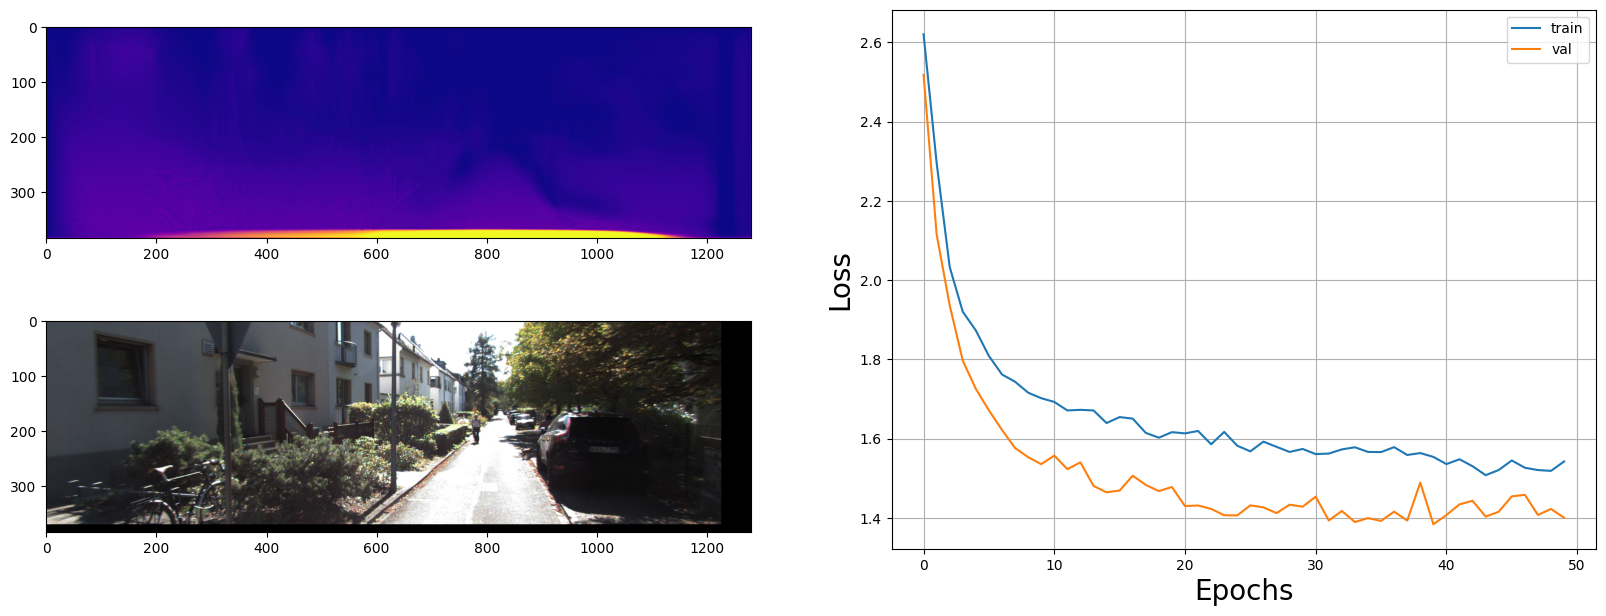

Epoch 50 of 50 took 154.675s



In [ ]:
train_network(
    model, opt, criterion, 50
)

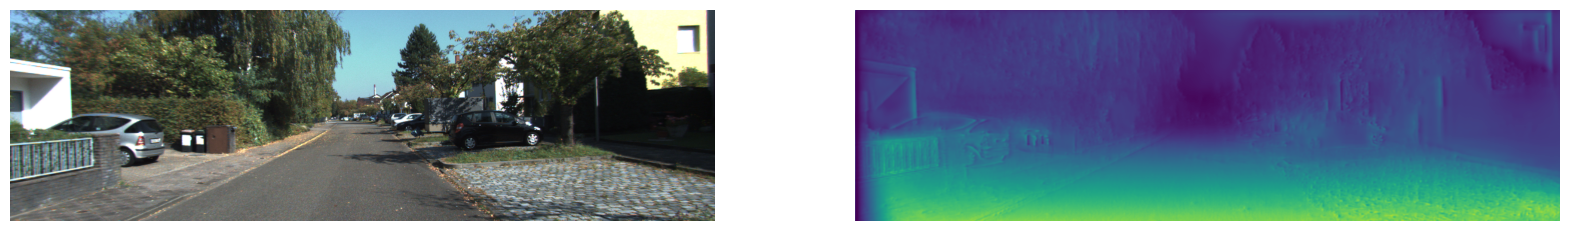

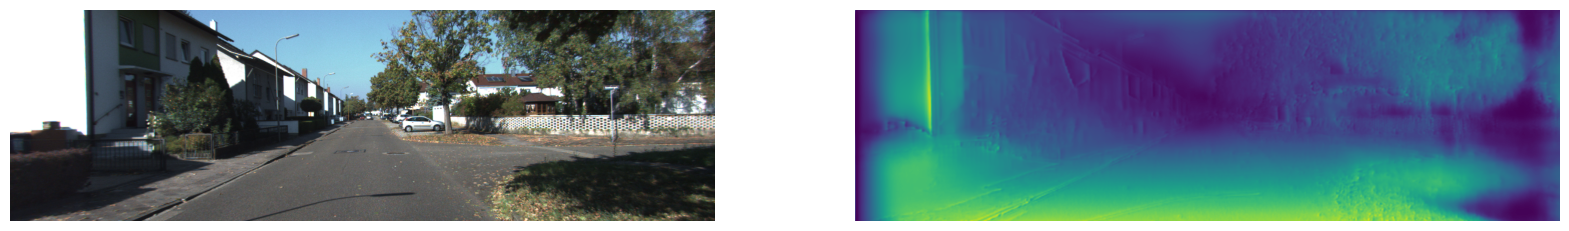

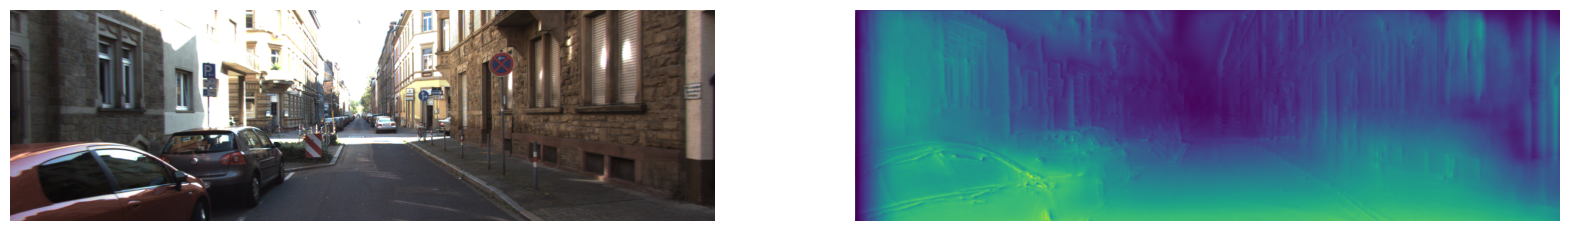

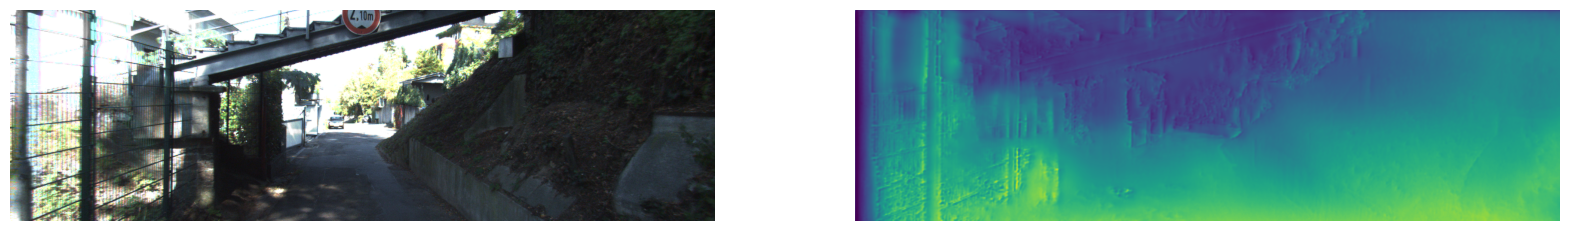

In [ ]:
for i in [0, 5, 10, 11]:
    left_image, right_image = validation_dataset[i]

    with torch.no_grad():
        disp_maps = model(left_image[None].cuda())
        last_map = disp_maps[-1][0, 0].cpu().numpy()[:-30, :-100]

    fig, axes = plt.subplots(1, 2, figsize=(20, 7), dpi=100)
    axes[0].imshow(left_image.permute(1, 2, 0)[:-30, :-100])
    axes[1].imshow(last_map)
    axes[0].axis('off'); axes[1].axis('off');
    plt.show()